In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import os
# os.environ['USE_PYGEOS'] = '0'
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
# import constants as c
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

In [2]:
# define scenario
scenario_name = 'Seattle'
input_dir = 'inputs_' + scenario_name
output_dir = 'outputs_' + scenario_name
plot_dir = 'plots_' + scenario_name
region_code = [411, 531, 532, 539]
# region_code = [62, 64, 65, 69]
focus_region = 531
lehd_file = 'WA_naics.csv'
map_file = scenario_name + '_freight.geojson'

In [3]:
synthfirm_all = read_csv(os.path.join(output_dir, 'synthetic_firms.csv'))
region_map = gpd.read_file(os.path.join(input_dir, map_file))
mesozone_id_lookup = read_csv(os.path.join(input_dir, 'zonal_id_lookup_final.csv'))
lehd_validation = read_csv(os.path.join(input_dir, lehd_file))
# synthfirm_output = read_csv(os.path.join(output_dir, 'processed_b2b_flow_summary_mesozone.csv'))

# calculate land area
region_map.loc[:, "area"] = \
region_map['geometry'].to_crs({'proj':'cea'}).map(lambda p: p.area / 10**6) 
# sf_map.loc[:, "area"] = sf_map.area/ 10**6 # km^2
region_map.head(5)

,GEOID,FAFID,MESOZONE,CBPZONE,geometry,area
0,122,122,20024,24,"POLYGON ((-80.03773 26.11450, -80.04092 26.092...",23535.047272
1,129,129,20027,27,"MULTIPOLYGON (((-80.86146 28.25051, -80.86145 ...",109346.499992
2,124,124,20026,26,"POLYGON ((-82.06476 28.17158, -82.06429 28.171...",8628.106605
3,123,123,20025,25,"POLYGON ((-81.37510 28.08510, -81.37547 28.085...",17079.982850
4,121,121,20023,23,"POLYGON ((-82.04854 29.72410, -82.04851 29.724...",11720.596000


In [4]:
print(synthfirm_all.columns)
firm_by_zone = synthfirm_all.groupby(['MESOZONE']).agg({'BusID':'count',
                                                       'Emp':'sum'})
firm_by_zone = firm_by_zone.reset_index()
firm_by_zone.columns = ['MESOZONE', 'firm_count', 'employment_count']
firm_by_zone.head(5)

print(firm_by_zone[['firm_count', 'employment_count']].sum())
firm_by_zone = pd.merge(firm_by_zone, mesozone_id_lookup, 
                        on = 'MESOZONE', how = 'left')
firm_by_zone.head(5)

Index(['CBPZONE', 'FAFZONE', 'esizecat', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'ZIPCODE'],
      dtype='object')
firm_count          8.418623e+06
employment_count    1.455969e+08
dtype: float64


,MESOZONE,firm_count,employment_count,GEOID,FAFID,CBPZONE,FAFNAME
0,20001,31921,6.046950e+05,11,11,1,Birmingham
1,20002,15124,2.560150e+05,12,12,2,Mobile
2,20003,60550,1.087290e+06,19,19,3,Rest of AL
3,20004,49731,3.507497e+05,20,20,4,Alaska
4,20005,98975,2.061311e+06,41,41,5,Phoenix


In [5]:
# select synthetic firms within study area
firm_in_study_area = \
firm_by_zone.loc[firm_by_zone['FAFID'].isin(region_code)]
print(firm_in_study_area.firm_count.sum())
# sf_map_with_firm = sf_map.merge(firm_in_austin, on='MESOZONE', how='inner')
# sf_map_with_firm.head(5)
synthfirm_in_study_area = synthfirm_all.loc[synthfirm_all['CBPZONE'] > 1000]
print(synthfirm_in_study_area.Emp.sum())
print(len(synthfirm_all.Industry_NAICS6_Make.unique()))
print(len(synthfirm_in_study_area.Industry_NAICS6_Make.unique()))

synthfirm_in_study_area.head(5)

287778
4644927.2103229705
391
387


,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,ZIPCODE
8130845,41003,411,1,113000,25,5.474719,4953373,410030103002,97324
8130846,41003,411,1,113000,25,5.474719,4953374,410030104001,97324
8130847,41003,411,1,113000,25,5.474719,4954489,410030001002,97333
8130848,41003,411,1,113000,25,5.474719,4954490,410030104003,97333
8130849,41003,411,1,113000,25,5.474719,4954491,410030104001,97333


In [6]:
# get synthetic firms by county
firm_in_study_area_by_county = firm_in_study_area.groupby('CBPZONE')[['employment_count']].sum()
firm_in_study_area_by_county = firm_in_study_area_by_county.reset_index()
firm_in_study_area_by_county.head(5)

mesozone_id_lookup_short = mesozone_id_lookup[['MESOZONE', 'GEOID']]
firm_in_study_area_by_cbg = firm_in_study_area.groupby('MESOZONE')[['employment_count']].sum()
firm_in_study_area_by_cbg = firm_in_study_area_by_cbg.reset_index()
firm_in_study_area_by_cbg = pd.merge(firm_in_study_area_by_cbg,
                                     mesozone_id_lookup_short,
                                     on = 'MESOZONE', how = 'left')
firm_in_study_area_by_cbg.head(5)

,MESOZONE,employment_count,GEOID
0,410030001001,337.642481,410030001001
1,410030001002,445.325360,410030001002
2,410030001003,61.842809,410030001003
3,410030001004,578.559612,410030001004
4,410030002021,544.174642,410030002021


In [7]:
# compare to LEHD data
lehd_validation.head(5)
print(lehd_validation.columns)

list_of_attr = ['n11', 'n21', 'n22', 'n23', 'n3133', 'n42',
                'n4445', 'n4849', 'n51', 'n52', 'n53', 'n54', 
                'n55', 'n56', 'n61', 'n62', 'n71', 'n72', 'n81', 'n92']
lehd_validation = pd.merge(lehd_validation,mesozone_id_lookup,
                               on = 'GEOID', how = 'left')
lehd_validation.loc[:, 'total'] = lehd_validation.loc[:, list_of_attr].sum(axis = 1)
lehd_validation.head(5)


Index(['GEOID', 'metalayer_id', 'n11', 'n21', 'n22', 'n23', 'n3133', 'n42',
       'n4445', 'n4849', 'n51', 'n52', 'n53', 'n54', 'n55', 'n56', 'n61',
       'n62', 'n71', 'n72', 'n81', 'n92'],
      dtype='object')


,GEOID,metalayer_id,n11,n21,n22,n23,n3133,n42,n4445,n4849,...,n62,n71,n72,n81,n92,FAFID,MESOZONE,CBPZONE,FAFNAME,total
0,530019501001,53001950,36,0,0,0,0,10,9,0,...,0,0,1,0,0,539.0,5.300195e+11,53001.0,Rest of WA,58
1,530019501002,53001950,2,0,0,7,0,11,26,0,...,107,0,150,2,1,539.0,5.300195e+11,53001.0,Rest of WA,404
2,530019501003,53001950,1,0,3,2,7,33,40,5,...,8,1,11,16,241,539.0,5.300195e+11,53001.0,Rest of WA,424
3,530019502001,53001950,19,0,0,0,2,0,8,0,...,0,1,2,0,5,539.0,5.300195e+11,53001.0,Rest of WA,72
4,530019502002,53001950,13,0,0,2,0,1,7,22,...,1,8,0,0,13,539.0,5.300195e+11,53001.0,Rest of WA,120


4492024
4644927.2103229705
9893.1 1.0


,County,LEHD employment,SynthFirm employment
0,41003.0,38589,38786.000
1,41005.0,166293,169962.375
2,41009.0,10894,10894.000
3,41043.0,45360,46363.000
4,41047.0,154094,155559.000


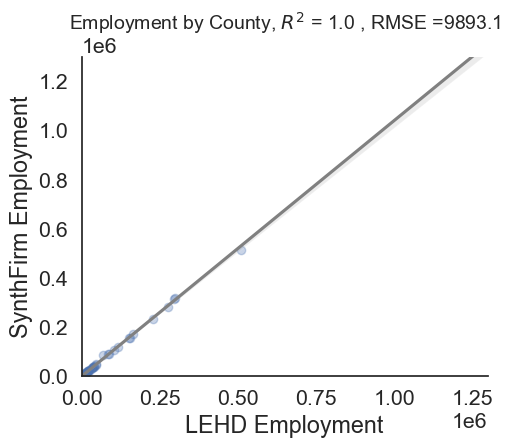

In [8]:
lehd_firm_by_county = lehd_validation.groupby('CBPZONE')[['total']].sum()
lehd_firm_by_county = lehd_firm_by_county.reset_index()
# # print(lehd_firm_by_county.head(5))
firm_comparison_by_county = pd.merge(lehd_firm_by_county, 
                                     firm_in_study_area_by_county,
                                     on = 'CBPZONE',
                                     how = 'inner')
firm_comparison_by_county.columns = ['County', 'LEHD employment', 'SynthFirm employment']
rmse_emp = mean_squared_error(firm_comparison_by_county['LEHD employment'], 
                              firm_comparison_by_county['SynthFirm employment'], squared = False)
r2_emp = r2_score(firm_comparison_by_county['LEHD employment'], 
                  firm_comparison_by_county['SynthFirm employment'])
rmse_emp = np.round(rmse_emp, 1)
r2_emp = np.round(r2_emp, 2)
print(firm_comparison_by_county['LEHD employment'].sum())
print(firm_comparison_by_county['SynthFirm employment'].sum())
print(rmse_emp, r2_emp)
plt.style.use('seaborn-v0_8-white')
# plt.rcParams['axes.facecolor'] = 'white'
sns.set(font_scale=1.4)  # crazy big
sns.set_style("white")
sns.lmplot(
    data=firm_comparison_by_county,
    x="LEHD employment", y="SynthFirm employment", 
    height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, 
    scatter_kws = {'alpha':0.3})
# g.set_facecolor("white")

plt.xlim([0, 1300000])
plt.ylim([0, 1300000])
plt.xlabel('LEHD Employment')
plt.ylabel('SynthFirm Employment')
plt.title('Employment by County, $R^{2}$ = ' + str(r2_emp) + \
          ' , RMSE =' + str(rmse_emp), fontsize = 14)
plt.savefig(os.path.join(plot_dir, 'emp_by_county_validation.png'), dpi = 200,
           bbox_inches = 'tight')

firm_comparison_by_county.head(5)

4457920
4644927.2103229705
1377.7 0.63


,GEOID,LEHD employment,SynthFirm employment
0,410030001001,250,337.642481
1,410030001002,706,445.325360
2,410030001003,93,61.842809
3,410030001004,575,578.559612
4,410030002021,666,544.174642


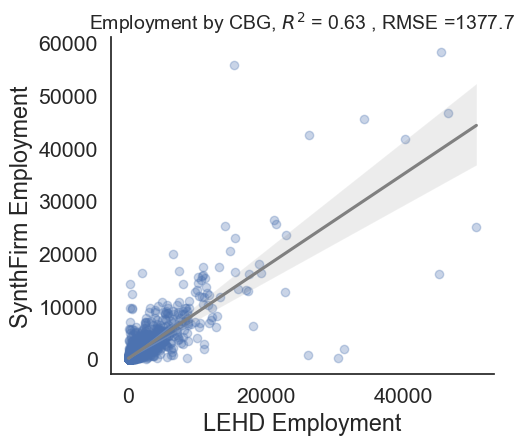

In [9]:
# compare results by CBG
lehd_firm_by_cbg = lehd_validation.groupby('GEOID')[['total']].sum()
lehd_firm_by_cbg = lehd_firm_by_cbg.reset_index()
# # print(lehd_firm_by_county.head(5))
firm_in_study_area_by_cbg.drop(columns = 'MESOZONE', inplace = True)
firm_comparison_by_cbg = pd.merge(lehd_firm_by_cbg, 
                                     firm_in_study_area_by_cbg,
                                     on = 'GEOID',
                                     how = 'inner')
firm_comparison_by_cbg.columns = ['GEOID', 'LEHD employment', 'SynthFirm employment']
rmse_emp = mean_squared_error(firm_comparison_by_cbg['LEHD employment'], 
                              firm_comparison_by_cbg['SynthFirm employment'], squared = False)
r2_emp = r2_score(firm_comparison_by_cbg['LEHD employment'], 
                  firm_comparison_by_cbg['SynthFirm employment'])
rmse_emp = np.round(rmse_emp, 1)
r2_emp = np.round(r2_emp, 2)
print(firm_comparison_by_cbg['LEHD employment'].sum())
print(firm_comparison_by_cbg['SynthFirm employment'].sum())
print(rmse_emp, r2_emp)
plt.style.use('seaborn-v0_8-white')
# plt.rcParams['axes.facecolor'] = 'white'
sns.set(font_scale=1.4)  # crazy big
sns.set_style("white")
sns.lmplot(
    data=firm_comparison_by_cbg,
    x="LEHD employment", y="SynthFirm employment", 
    height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, 
    scatter_kws = {'alpha':0.3})
# g.set_facecolor("white")

# plt.xlim([0, 1300000])
# plt.ylim([0, 1300000])
plt.xlabel('LEHD Employment')
plt.ylabel('SynthFirm Employment')
plt.title('Employment by CBG, $R^{2}$ = ' + str(r2_emp) + \
          ' , RMSE =' + str(rmse_emp), fontsize = 14)
plt.savefig(os.path.join(plot_dir, 'emp_by_CBG_validation.png'), dpi = 200,
           bbox_inches = 'tight')

firm_comparison_by_cbg.head(5)

4492024
4644927.2103229705
['11' '21' '22' '23' '31' '32' '33' '42' '44' '45' '4A' '48' '49' '51'
 '52' '53' '54' '55' '56' '61' '62' '71' '72' '81' 'S0']


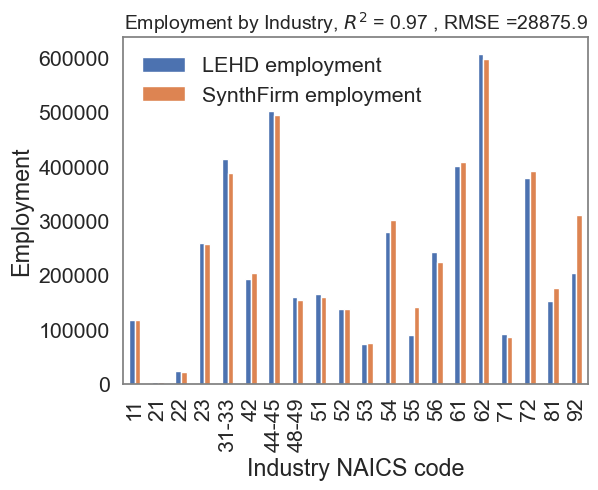

In [10]:
# compare to LEHD data
#lehd_validation.head(5)
industry_lookup = {'11':'11', '21':'21', '22':'22', '23':'23',
                   '31':'31-33', '32':'31-33', '33':'31-33',
                   '42':'42', '44':'44-45', '45':'44-45', '4A': '44-45',
                   '48':'48-49', '49':'48-49', '51':'51',
                   '52':'52', '53':'53', '54':'54', '55':'55',
                   '56':'56', '61':'61', '62':'62', '71':'71',
                   '72':'72', '81':'81', '92':'92', 'S0': '92'}
selected_counties = firm_comparison_by_county.County.unique()
lehd_firm_by_industry = pd.melt(lehd_validation, id_vars = 'CBPZONE',
                               value_vars=list_of_attr, 
                                var_name='industry', value_name='emp')

lehd_firm_by_industry = lehd_firm_by_industry.reset_index()
lehd_firm_by_industry.loc[:, 'industry'] = \
lehd_firm_by_industry.loc[:, 'industry'].str.split('n').str[1]

lehd_firm_by_industry.loc[lehd_firm_by_industry['industry'] == '3133', 'industry'] = '31-33'
lehd_firm_by_industry.loc[lehd_firm_by_industry['industry'] == '4445', 'industry'] = '44-45'
lehd_firm_by_industry.loc[lehd_firm_by_industry['industry'] == '4849', 'industry'] = '48-49'
lehd_firm_by_industry = \
lehd_firm_by_industry.loc[lehd_firm_by_industry['CBPZONE'].isin(selected_counties)]


lehd_firm_by_industry = lehd_firm_by_industry.groupby(['industry'])[['emp']].sum()
print(lehd_firm_by_industry['emp'].sum())
# lehd_firm_by_industry.head(5)
print(synthfirm_in_study_area.loc[:, 'Emp'].sum())
synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].astype(str)
synthfirm_in_study_area.loc[:, 'NAICS2'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].str[:2]
print(synthfirm_in_study_area.loc[:, 'NAICS2'].unique())
synthfirm_in_study_area.loc[:, 'industry'] = synthfirm_in_study_area.loc[:, 'NAICS2'].map(industry_lookup)

firm_in_study_area_by_industry = synthfirm_in_study_area.groupby(['industry'])[['Emp']].sum()
# print(firm_in_study_area_by_industry['Emp'].sum())
firm_in_study_area_by_industry = firm_in_study_area_by_industry.reset_index()
firm_comparison_by_industry = pd.merge(lehd_firm_by_industry,
                                       firm_in_study_area_by_industry,
                                       on = 'industry', how = 'inner')

firm_comparison_by_industry.columns = ['Industry', 'LEHD employment',  'SynthFirm employment']
rmse_emp = mean_squared_error(firm_comparison_by_industry['LEHD employment'], 
                              firm_comparison_by_industry['SynthFirm employment'], squared = False)
r2_emp = r2_score(firm_comparison_by_industry['LEHD employment'], 
                  firm_comparison_by_industry['SynthFirm employment'])
rmse_emp = np.round(rmse_emp, 1)
r2_emp = np.round(r2_emp, 2)

# print(firm_comparison_by_industry['SynthFirm employment'].sum())
# print(firm_comparison_by_industry.head(5))
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("white")
sns.set(font_scale=1.4)  # crazy big
fig, ax = plt.subplots(figsize = (6,4.5))
ax.set(facecolor = "white")
firm_comparison_by_industry.plot(kind = 'bar',
    x="Industry", ax = ax)
plt.xlabel('Industry NAICS code')
plt.ylabel('Employment')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='gray')
# ax.patch.set_edgecolor('black')  

# ax.patch.set_linewidth(1)  
plt.title('Employment by Industry, $R^{2}$ = ' + str(r2_emp) + \
          ' , RMSE =' + str(rmse_emp), fontsize = 14)
plt.savefig(os.path.join(plot_dir, 'emp_by_industry_validation.png'), dpi = 200, 
            bbox_inches = 'tight')

# firm_in_study_area_by_industry

In [11]:
firm_in_region = firm_by_zone.loc[firm_by_zone['FAFID'].isin([focus_region])]
firm_in_region.loc[:, 'MESOZONE'] = \
firm_in_region.loc[:, 'MESOZONE'].astype(int).astype(str).str.zfill(12)
region_map.loc[:, 'MESOZONE'] = \
region_map.loc[:, 'MESOZONE'].astype(int).astype(str).str.zfill(12)

region_map_with_firm = region_map.merge(firm_in_region, on='MESOZONE', how='inner')
region_map_with_firm.loc[:, 'firm_per_area'] = \
region_map_with_firm.loc[:, 'firm_count'] / region_map_with_firm.loc[:, 'area']
region_map_with_firm.loc[:, 'emp_per_area'] = \
region_map_with_firm.loc[:, 'employment_count'] / region_map_with_firm.loc[:, 'area']
region_map_with_firm.head(5)

,GEOID_x,FAFID_x,MESOZONE,CBPZONE_x,geometry,area,firm_count,employment_count,GEOID_y,FAFID_y,CBPZONE_y,FAFNAME,firm_per_area,emp_per_area
0,530330293053,531,530330293053,53033,"MULTIPOLYGON (((-122.21292 47.42784, -122.2129...",0.891907,3,177.106681,530330293053,531,53033,Seattle,3.363578,198.570706
1,530330205002,531,530330205002,53033,"MULTIPOLYGON (((-122.31347 47.75749, -122.3085...",0.435127,11,94.881945,530330205002,531,53033,Seattle,25.279966,218.055664
2,530530620003,531,530530620003,53053,"MULTIPOLYGON (((-122.42101 47.23054, -122.4164...",0.291051,4,21.476013,530530620003,531,53053,Seattle,13.743297,73.787804
3,530530613002,531,530530613002,53053,"MULTIPOLYGON (((-122.46102 47.25418, -122.4538...",0.254453,6,138.387975,530530613002,531,53053,Seattle,23.579971,543.864082
4,530330105001,531,530330105001,53033,"MULTIPOLYGON (((-122.38146 47.56287, -122.3792...",0.266125,198,1861.860081,530330105001,531,53033,Seattle,744.009875,6996.173167


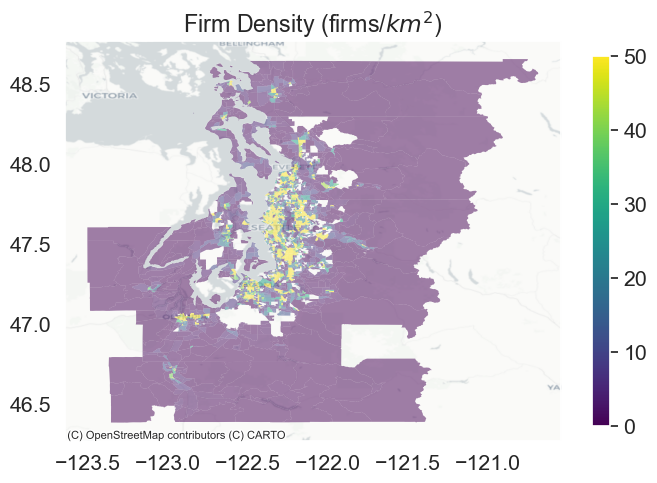

In [12]:
ax = region_map_with_firm.plot(figsize = (8,6), column = 'firm_per_area', 
                           vmin=0, vmax=50, alpha = 0.5, legend=True,
                              cmap='viridis',
                              linewidth=0.01, 
                            legend_kwds = {'shrink': 0.8}, edgecolor='none')
cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.CartoDB.Positron)
ax.grid(False)
plt.title('Firm Density (firms/$km^{2}$)')
plt.savefig(os.path.join(plot_dir, 'region_firm_count.png'), dpi = 300)

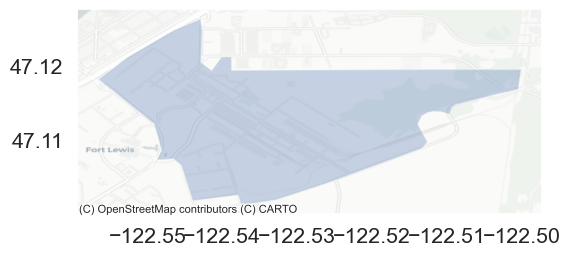

In [26]:
# plot the missing zone
geoid = '530530729073'
region_map_troubleshoot = \
region_map.loc[region_map['MESOZONE']==geoid]
ax = region_map_troubleshoot.plot(figsize = (6,5), alpha = 0.3)
cx.add_basemap(ax, crs = 'EPSG:4326', 
               source = cx.providers.CartoDB.Positron, zoom = 14)
ax.grid(False)


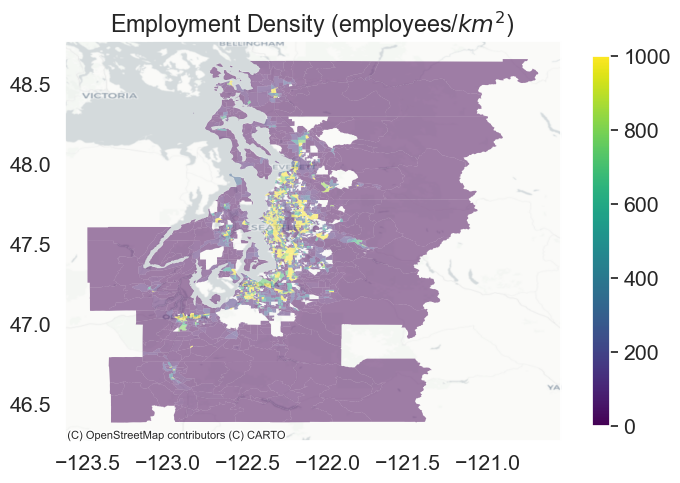

In [13]:
ax = region_map_with_firm.plot(figsize = (8,6), column = 'emp_per_area', 
                            vmin=0, vmax=1000, alpha = 0.5, legend=True,
                               cmap='viridis',
                              linewidth=0.01, 
                            legend_kwds = {'shrink': 0.8}, edgecolor='none')
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.CartoDB.Positron)
plt.title('Employment Density (employees/$km^{2}$)')
ax.grid(False)
plt.savefig(os.path.join(plot_dir, 'region_emp_count.png'), dpi = 300)

In [14]:
# plot production
print(synthfirm_output.columns)
production_in_region = synthfirm_output.loc[synthfirm_output['orig_FAFID'].isin([focus_region])]
production_in_region = production_in_region.groupby(['SellerZone'])[['ShipmentLoad']].sum()
production_in_region = production_in_region.reset_index()
production_in_region = production_in_region.rename(columns = {'SellerZone': 'MESOZONE'})

region_map_with_production = \
region_map.merge(production_in_region, on='MESOZONE', how='inner')
region_map_with_production.loc[:, 'production_per_area'] = \
region_map_with_production.loc[:, 'ShipmentLoad'] * 0.907185/ \
region_map_with_production.loc[:, 'area']
# sf_map_with_firm.loc[:, 'emp_per_area'] = sf_map_with_firm.loc[:, 'employment_count'] / sf_map_with_firm.loc[:, 'area']
region_map_with_production.head(5)

Index(['Unnamed: 0', 'SellerZone', 'orig_FAFID', 'orig_FAFNAME', 'BuyerZone',
       'dest_FAFID', 'dest_FAFNAME', 'Commodity_SCTG', 'SCTG_Group',
       'SCTG_Name', 'mode_choice', 'tmiles', 'ShipmentLoad', 'count',
       'outbound', 'inbound', 'Distance'],
      dtype='object')


,GEOID,CBPZONE,MESOZONE,geometry,area,ShipmentLoad,production_per_area
0,530330293053,53033,1923.0,"MULTIPOLYGON (((-122.21485 47.42306, -122.2075...",0.891907,1.530769,1.556990
1,530330205002,53033,1429.0,"MULTIPOLYGON (((-122.31348 47.75574, -122.3133...",0.435125,14.585901,30.409891
2,530330105001,53033,1329.0,"MULTIPOLYGON (((-122.38153 47.55563, -122.3799...",0.266125,39.455120,134.497124
3,530330053012,53033,1118.0,"MULTIPOLYGON (((-122.31764 47.66130, -122.3119...",0.203044,0.355617,1.588868
4,530530713073,53053,3003.0,"MULTIPOLYGON (((-122.35733 47.13985, -122.3361...",2.611525,10.392709,3.610194


<Axes: >

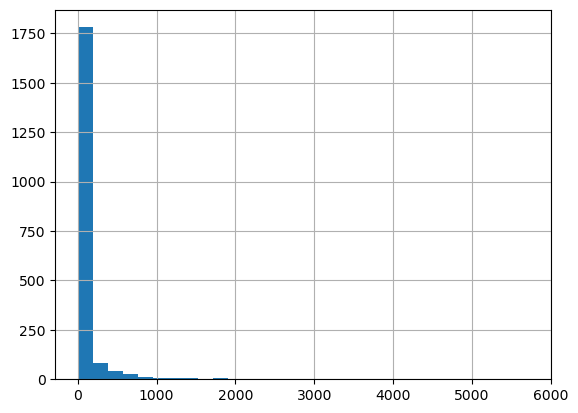

In [7]:
region_map_with_production['production_per_area'].hist(bins= 30)

In [15]:
ax = region_map_with_production.plot(figsize = (8,6), column = 'production_per_area', 
                            alpha = 0.5, legend=True,
                            vmin = 0, vmax = 100,
                            # norm=matplotlib.colors.LogNorm(vmin=region_map_with_production.production_per_area.min(), 
                            #                                vmax=region_map_with_production.production_per_area.max()),
                            cmap='viridis',
                            linewidth=0.01, 
                            legend_kwds = {'shrink': 0.9})
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.CartoDB.Positron)

ax.grid(False)
plt.title('Commodity Production (1000 tons/$km^{2}$)')
plt.savefig(os.path.join(plot_dir, 'region_production_allmodes.png'), dpi = 300)

NameError: name 'region_map_with_production' is not defined

In [17]:
# print(synthfirm_output.columns)
attraction_in_region = synthfirm_output.loc[synthfirm_output['dest_FAFID'].isin([focus_region])]
attraction_in_region = attraction_in_region.groupby(['BuyerZone'])[['ShipmentLoad']].sum()
attraction_in_region = attraction_in_region.reset_index()
attraction_in_region = attraction_in_region.rename(columns = {'BuyerZone': 'MESOZONE'})

region_map_with_attraction = \
region_map.merge(attraction_in_region, on='MESOZONE', how='inner')
region_map_with_attraction.loc[:, 'attraction_per_area'] = \
region_map_with_attraction.loc[:, 'ShipmentLoad'] * 0.907185/ \
region_map_with_attraction.loc[:, 'area']
# sf_map_with_firm.loc[:, 'emp_per_area'] = sf_map_with_firm.loc[:, 'employment_count'] / sf_map_with_firm.loc[:, 'area']
region_map_with_attraction.head(5)

,GEOID,CBPZONE,MESOZONE,geometry,area,ShipmentLoad,attraction_per_area
0,530330293053,53033,1923.0,"MULTIPOLYGON (((-122.21485 47.42306, -122.2075...",0.891907,35.997044,36.613653
1,530330205002,53033,1429.0,"MULTIPOLYGON (((-122.31348 47.75574, -122.3133...",0.435125,113.824011,237.309704
2,530530620003,53053,2850.0,"MULTIPOLYGON (((-122.42057 47.22859, -122.4208...",0.291052,0.968752,3.019515
3,530530613002,53053,2824.0,"MULTIPOLYGON (((-122.46008 47.25006, -122.4529...",0.254453,11.749891,41.891058
4,530610527055,53061,3798.0,"MULTIPOLYGON (((-122.14092 48.04772, -122.1335...",0.595702,0.530103,0.807286


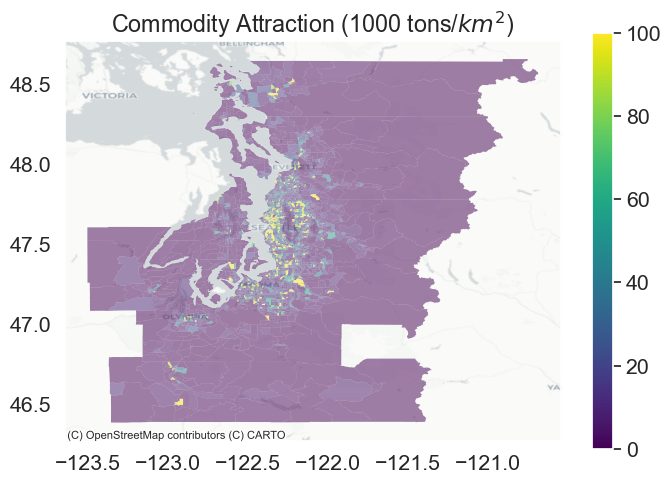

In [18]:
ax = region_map_with_attraction.plot(figsize = (8,6), column = 'attraction_per_area', 
                            alpha = 0.5, legend=True,
                            vmin = 0, vmax = 100,
                            # norm=matplotlib.colors.LogNorm(vmin=region_map_with_attraction.attraction_per_area.min(), 
                            #                                vmax=region_map_with_attraction.attraction_per_area.max()),
                                    cmap='viridis',
                            linewidth=0.01, 
                            legend_kwds = {'shrink': 0.9})
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.CartoDB.Positron)
plt.title('Commodity Attraction (1000 tons/$km^{2}$)')
ax.grid(False)
plt.savefig(os.path.join(plot_dir, 'region_attraction_allmodes.png'), dpi = 200)